# Vehicular Accidents in New York City

---

## Import Libraries, Access API,  Create DataFrame, and Sample Data

In [3]:
# Ignore non-fatal warnings
import warnings
warnings.filterwarnings("ignore")

# Import other dependencies, including sodapy, which is identified in the API docs as crucial
import pandas as pd
from sodapy import Socrata
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import scipy.stats as st
from scipy.stats import linregress
import json
import os

# Import API keys & app tokens
from api_keys import api_key_regular
from api_keys import api_key_secret
from api_keys import app_token_regular
from api_keys import app_token_secret

# Create full url for API that includes app token
client = Socrata("data.cityofnewyork.us", app_token_regular)

# Return results as a JSON
results = client.get("h9gi-nx95")

# Convert to pandas DataFrame
results_values_df = pd.DataFrame.from_records(results)

# Print all column names
column_names = results_values_df.columns
for name in column_names:
    print(name)

# Sample values
results_values_df.head(20)

ModuleNotFoundError: No module named 'api_keys'

## DataFrame Clean-up and Hygiene

In [7]:
# Exclude columns that are unnecessary for the analysis
excluded_columns = ["on_street_name", "off_street_name", "number_of_pedestrians_injured", "number_of_pedestrians_killed", "number_of_cyclist_injured",
"number_of_cyclist_killed", "number_of_motorist_injured", "number_of_motorist_killed", "contributing_factor_vehicle_2", "vehicle_type_code2", "zip_code", "latitude", "longitude",
"location", "cross_street_name", "cross_street_name", "contributing_factor_vehicle_3", "vehicle_type_code_3", "contributing_factor_vehicle_4", "vehicle_type_code_4", "contributing_factor_vehicle_5", "vehicle_type_code_5"]
filtered_df = results_values_df.loc[:, ~results_values_df.columns.isin(excluded_columns)]

# Drop rows with missing values
filtered_df = filtered_df.dropna()

# Drop rows where "contributing_factor_vehicle_1" is "Unspecified"
filtered_df = filtered_df[filtered_df["contributing_factor_vehicle_1"] != "Unspecified"]

# Reorder columns with "collision_id" as the first column so that each crash can be easily identified if needed
column_order = ["collision_id"] + [col for col in filtered_df.columns if col != "collision_id"]
filtered_df = filtered_df[column_order]

# Counts by column, to make sure analysis still has a sufficient number of records after previous drops
column_counts = filtered_df.count()
print(column_counts)

# Sample values
filtered_df.head(20)

collision_id                     456
crash_date                       456
crash_time                       456
number_of_persons_injured        456
number_of_persons_killed         456
contributing_factor_vehicle_1    456
vehicle_type_code1               456
borough                          456
dtype: int64


,collision_id,crash_date,crash_time,number_of_persons_injured,number_of_persons_killed,contributing_factor_vehicle_1,vehicle_type_code1,borough
8,4487074,2021-12-14T00:00:00.000,21:10,0,0,Driver Inexperience,Sedan,BROOKLYN
9,4486519,2021-12-14T00:00:00.000,14:58,0,0,Passing Too Closely,Sedan,MANHATTAN
11,4487127,2021-12-14T00:00:00.000,16:50,0,0,Turning Improperly,Sedan,QUEENS
14,4486635,2021-12-14T00:00:00.000,23:10,2,0,Reaction to Uninvolved Vehicle,Sedan,QUEENS
15,4486604,2021-12-14T00:00:00.000,17:58,0,0,Passing Too Closely,Tanker,BROOKLYN
16,4486991,2021-12-14T00:00:00.000,20:03,4,0,Steering Failure,Sedan,BROOKLYN
20,4486905,2021-12-11T00:00:00.000,4:45,0,0,Following Too Closely,Station Wagon/Sport Utility Vehicle,MANHATTAN
26,4486605,2021-12-14T00:00:00.000,20:13,0,0,Passing Too Closely,Sedan,BROOKLYN
28,4486556,2021-12-14T00:00:00.000,17:15,1,0,Passing or Lane Usage Improper,Bus,BROOKLYN
29,4486875,2021-12-14T00:00:00.000,22:49,0,0,Driver Inattention/Distraction,Taxi,BRONX


## Initial Plots for Exploration

## Bar Plot (absolute & percentage values) - Overall

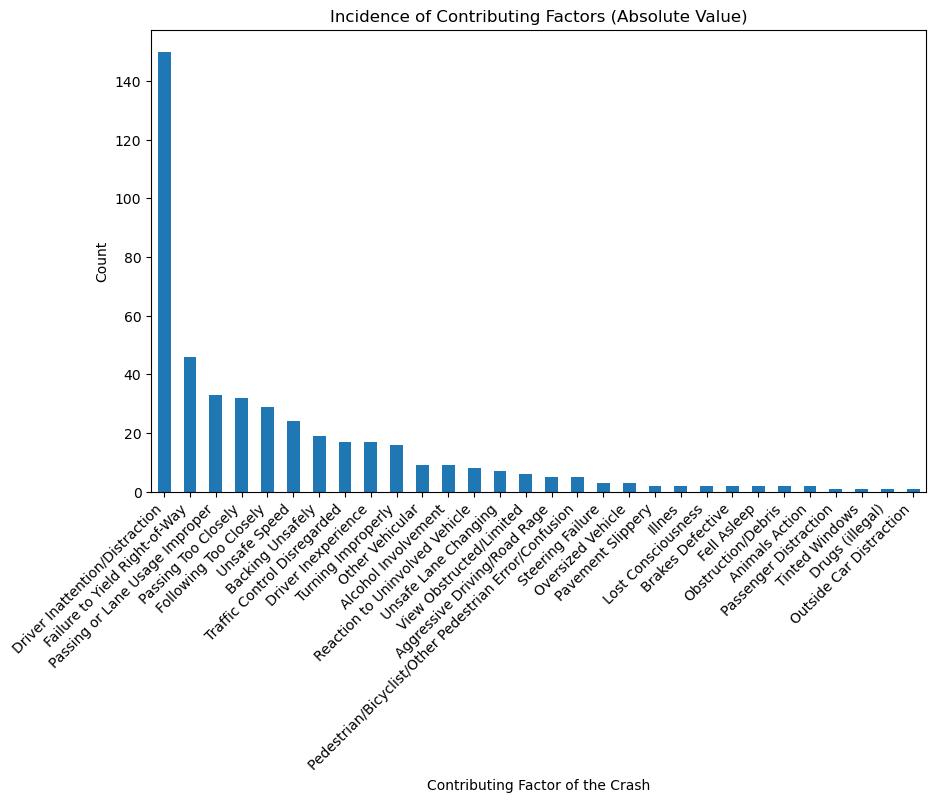

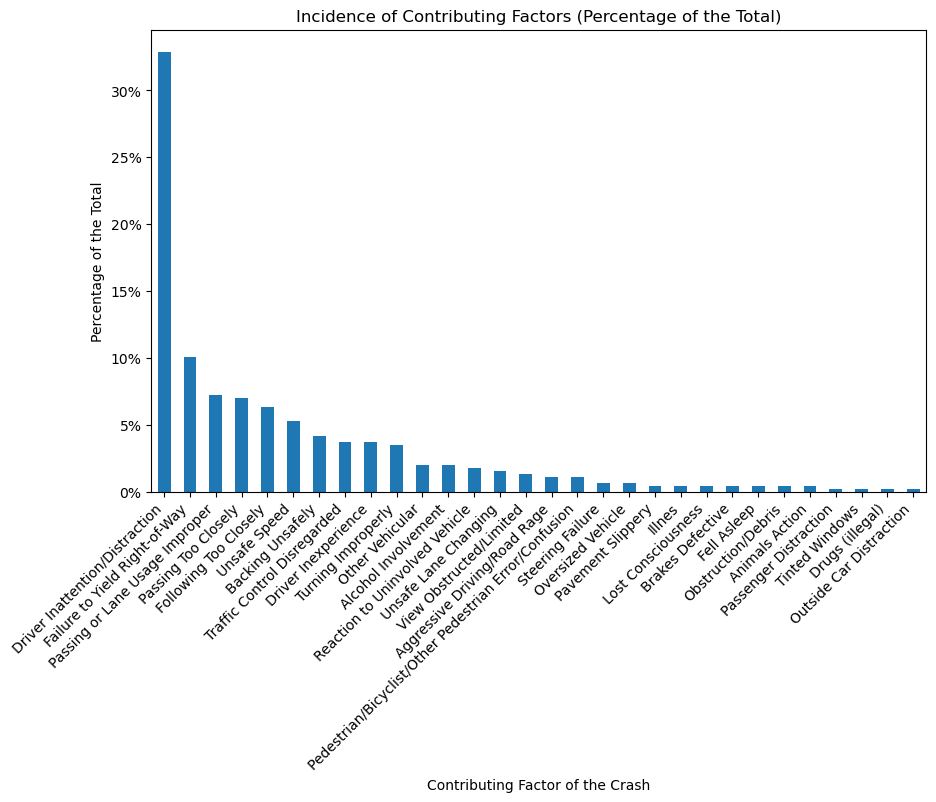

In [8]:
# Calculate factor counts and percentages
factor_counts = filtered_df["contributing_factor_vehicle_1"].value_counts()
factor_percentages = filtered_df["contributing_factor_vehicle_1"].value_counts(normalize=True) * 100

# Create a bar plot for absolute numbers of contributing factors of vehicular crashes
fig, ax = plt.subplots(figsize=(10, 6))
factor_counts.plot(kind="bar", ax=ax)
ax.set_xlabel("Contributing Factor of the Crash")
ax.set_ylabel("Count")
ax.set_title("Incidence of Contributing Factors (Absolute Value)")

# Rotate x-axis labels diagonally, to be more easily read
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Save the bar plot as png to a subdirectory for the presentation
plt.savefig("plots/absolute_number_of_crashes_barplot")

# Display the bar plot
plt.show()

# Create a similar bar plot, this time for percentages with percent signs
fig, ax = plt.subplots(figsize=(10, 6))
factor_percentages.plot(kind="bar", ax=ax)
ax.set_xlabel("Contributing Factor of the Crash")
ax.set_ylabel("Percentage of the Total")
ax.set_title("Incidence of Contributing Factors (Percentage of the Total)")
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))

# Rotate x-axis labels diagonally
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Save the bar plot for percentages as png for the presentation
plt.savefig("plots/percentage_of_crashes_barplot")

# Display the bar plot for percentages
plt.show()

## Initial Plots for Exploration

## Pie Plot (percentage values) - Overall

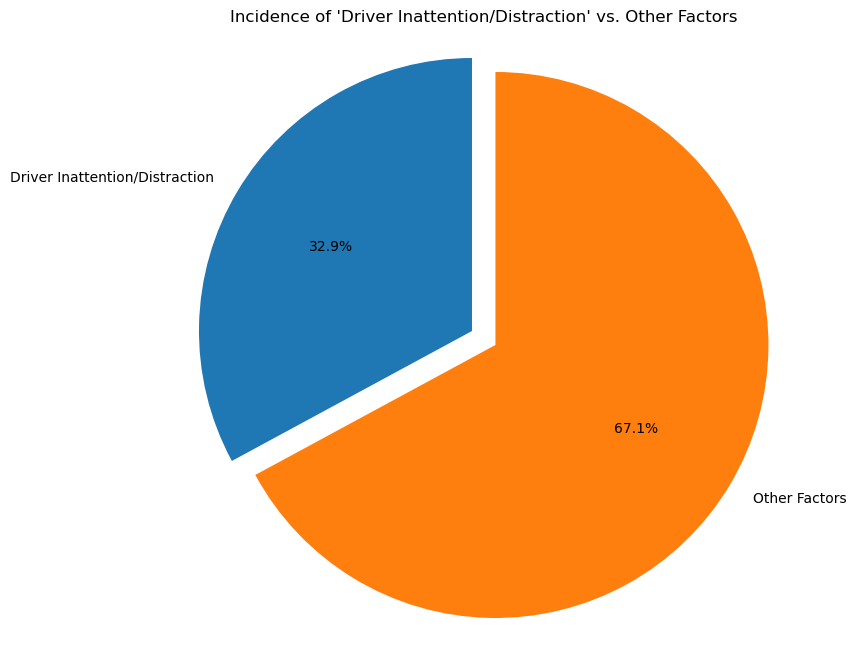

In [9]:
# Calculate sizes and labels for the pie plot
sizes = [
    filtered_df["contributing_factor_vehicle_1"].value_counts()["Driver Inattention/Distraction"],
    filtered_df["contributing_factor_vehicle_1"].value_counts().sum() - filtered_df["contributing_factor_vehicle_1"].value_counts()["Driver Inattention/Distraction"]
]
labels = ["Driver Inattention/Distraction", "Other Factors"]

# Define explode values to highlight "Driver Inattention/Distraction"
explode = (0.1, 0)

# Create a pie plot for "Driver Inattention/Distraction" vs. other factors
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title("Incidence of 'Driver Inattention/Distraction' vs. Other Factors")

# Save the bar plot for percentages as png for the presentation
plt.savefig("plots/percentage_of_crashes_pieplot")

# Display the pie plot
plt.show()

Does time of day correlate with more or less collisions by distracted drivers? What is the trend? - by Wed class - Debbie

Does day of the year correlate with more or less collisions by distracted drivers? What is the trend? - by Wed class - Debbie

Does a particular class of vehicle associate the most with distracted vehicular driving? - by Wed class - Susan

Is there a greater percentage of distracted-driving-related accidents in particular boros vs others - by Wed class - Susan

What are the relative percentages of factors associated with fatalities, injuries, or both? Do they mirror the causes of accidents in general (e.g., distracted driving causing the majority of them)? Comparison between reason & number of deaths/injuries for each type of accident - is distracted driving still so paramount? - by Wed class - Andi